## Thành viên nhóm:
#### Nguyễn Quỳnh Như - 520H0562 - 2.1 và 2.5
#### Trần Lê Gia Bảo - 520H0516 - 2.2 và 2.4 (Overfitting của 2.2)
#### Ngô Trọng Nhân - 520H0393 - 2.3 và 2.4 (Overfitting của 2.3)

# Titanic Prediction

Predicting survival on the Titanic using data, analyzing whether factors such as Pclass, gender, and age,... influence the likelihood of survival


## Nguyễn Quỳnh Như

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import time
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,  classification_report, confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier,StackingClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [109]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
gender_data = pd.read_csv('gender_submission.csv')

# Exploratory Data Analysis

### 1. Define data type of each column

In [110]:
# Display all informations
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [111]:
#check missing value
def display_missing(data):    
    for col in data.columns.tolist():          
        print('{} column missing values: {}'.format(col, data[col].isnull().sum()))
    print('\n')
    
display_missing(train_data)

PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2




#### Analyze the categorial data

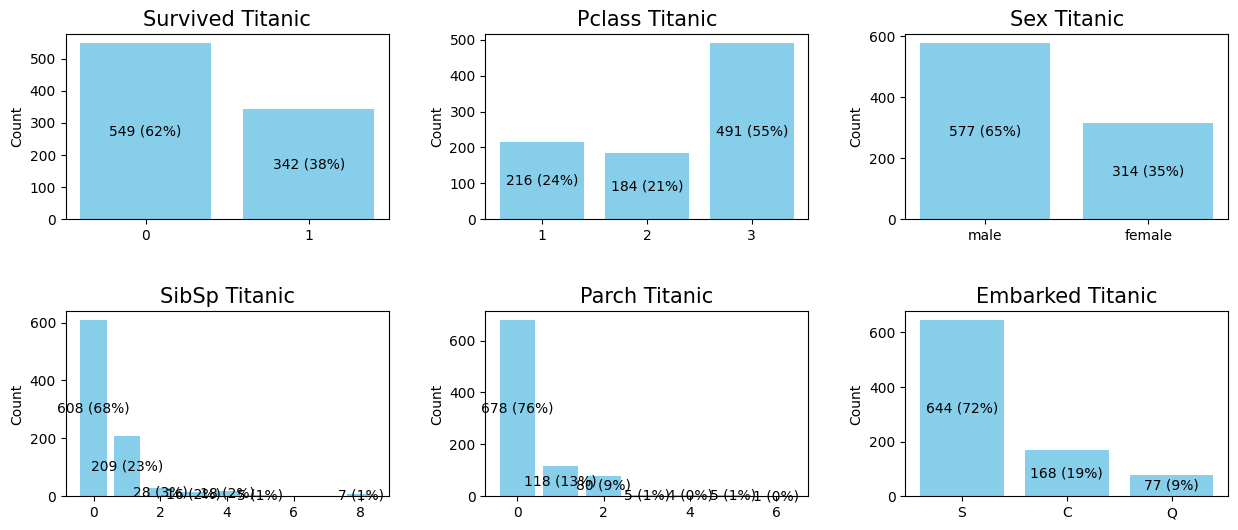

In [112]:
fig, myplot = plt.subplots(figsize=(15, 6), nrows=2, ncols=3)

categorical_features = ["Survived", "Pclass", "Sex", "SibSp", "Parch", "Embarked"]

row, col, num_cols = 0, 0, 3

for u in categorical_features:
    values_counts = train_data[u].value_counts()
    ax = myplot[row, col]
    
    # For "Survived" plot, set x-ticks to only 0 and 1 - for better performance
    if u == "Survived":
        ax.bar(values_counts.index, values_counts, color='skyblue')
        ax.set_xticks([0, 1])
    elif u == "Pclass":
        ax.bar(values_counts.index, values_counts, color='skyblue')
        ax.set_xticks([1, 2, 3])
    else:
        ax.bar(values_counts.index, values_counts, color='skyblue')

    ax.set_xlabel("")
    ax.set_title(u + " Titanic", fontsize=15)
    ax.set_ylabel("Count")
    col = col + 1
    if col == 3:
        col = 0
        row = row + 1

plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.3)

for v in range(2):
    for z in range(3):
        ax = myplot[v, z]
        for patch in ax.patches:
            label_x = patch.get_x() + patch.get_width() / 2
            label_y = patch.get_y() + patch.get_height() / 2
            ax.text(label_x, label_y,
                    f"{int(patch.get_height())} ({patch.get_height() / len(train_data[u]):.0%})",
                    horizontalalignment='center', verticalalignment='center')

plt.show()

#### Analyze the numeric data - Age

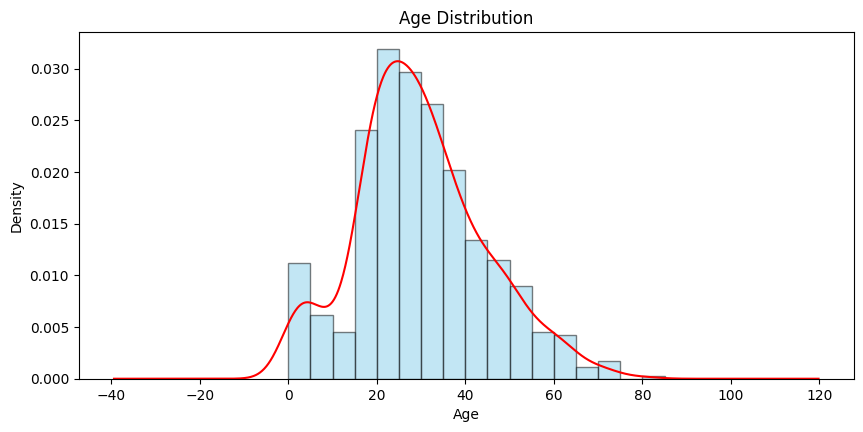

In [113]:
# Null and known ages
null_ages = pd.isnull(train_data['Age'])
known_ages = pd.notnull(train_data['Age'])
preimputation = train_data['Age'][known_ages]

# Explore Age distribution as a whole with kernel density estimate
plt.figure(figsize=(10, 4.5))
plt.hist(train_data['Age'].dropna(), bins=range(0, 100, 5), color='skyblue', edgecolor='black', density=True, alpha=0.5)
train_data['Age'].plot(kind='kde', color='red')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

#### Analyze the numeric data - Fare

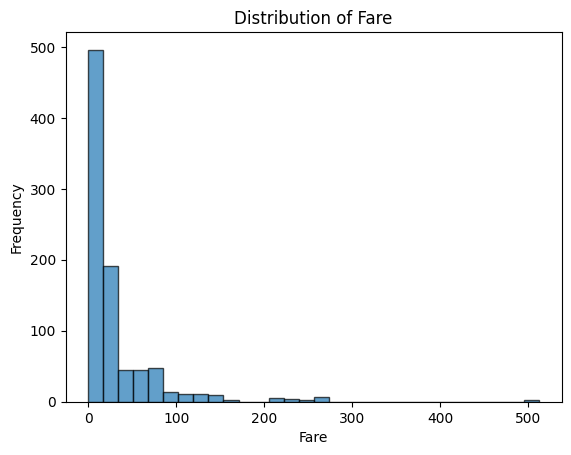

In [114]:
# Identify null and known ages
preimputation = train_data['Fare']

# Plot the distribution of ages before imputation
plt.hist(preimputation, bins=30, edgecolor='black', alpha=0.7)
plt.title('Distribution of Fare')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.show()

## Feature selection - Analyze relationship of feature and goal

#### Gender and survied

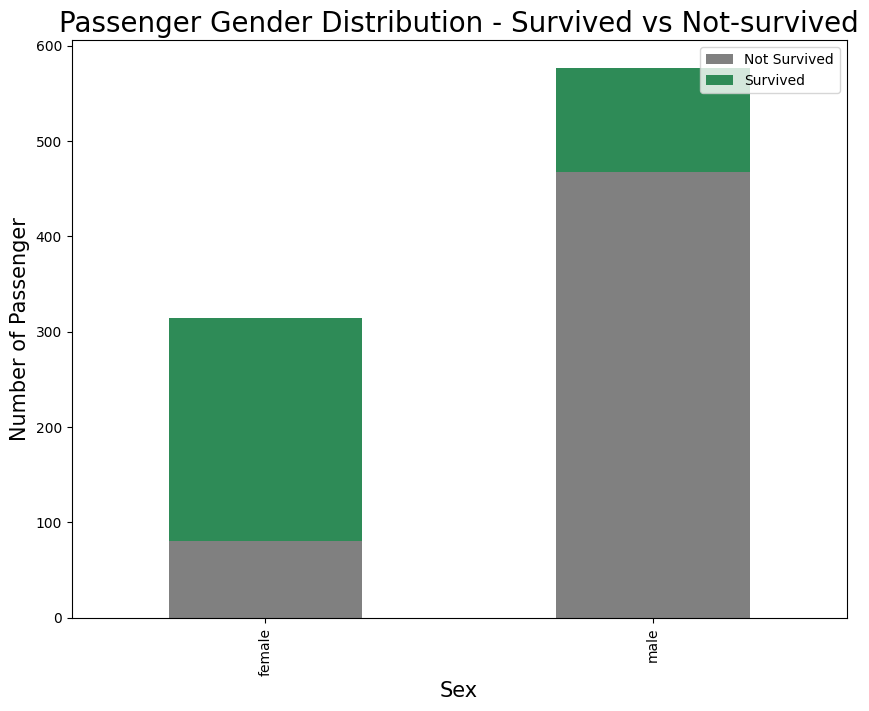

In [115]:
# Count plot for Passenger Gender Distribution
fig, myaxis = plt.subplots(figsize=(10, 7.5))

# Counting and plotting for Survived and Not Survived
survived_counts = train_data.groupby(['Sex', 'Survived']).size().unstack()
survived_counts.plot(kind='bar', stacked=True, color=['gray', 'seagreen'], ax=myaxis, linewidth=2)

# Fixing title, xlabel, and ylabel
myaxis.set_title("Passenger Gender Distribution - Survived vs Not-survived", fontsize=20)
myaxis.set_xlabel("Sex", fontsize=15)
myaxis.set_ylabel("Number of Passenger", fontsize=15)

# Adding legend
myaxis.legend(["Not Survived", "Survived"], loc='upper right')

plt.show()

#### PClasss and survived

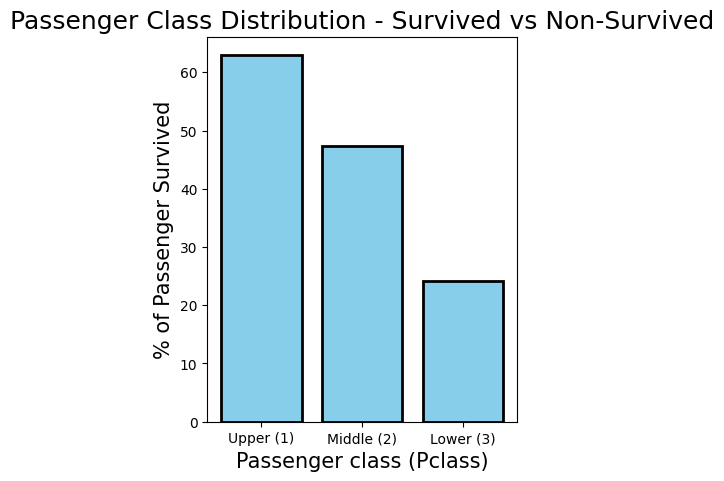

In [116]:
# Bar plot for Passenger Class Distribution
fig, pclass_bar = plt.subplots(figsize=(4, 5))

# Calculate the mean of Survived for each Pclass
survival_percentage = train_data.groupby('Pclass')['Survived'].mean()

# Bar plot
pclass_bar.bar(survival_percentage.index, survival_percentage * 100, color='skyblue', edgecolor='black', linewidth=2)

# Fixing title, xlabel, and ylabel
pclass_bar.set_title("Passenger Class Distribution - Survived vs Non-Survived", fontsize=18)
pclass_bar.set_xlabel("Passenger class (Pclass)", fontsize=15)
pclass_bar.set_ylabel("% of Passenger Survived", fontsize=15)

# Adding custom x-axis labels
labels = ['Upper (1)', 'Middle (2)', 'Lower (3)']
pclass_bar.set_xticks(survival_percentage.index)
pclass_bar.set_xticklabels(labels)

plt.show()

### Embarked against Survived

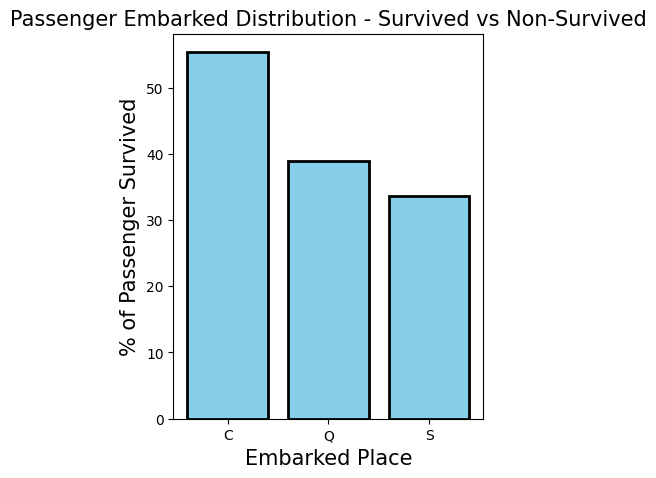

In [117]:
# Bar plot for Passenger Embarked Distribution
fig, embarked_bar = plt.subplots(figsize=(4, 5))

# Calculate the mean of Survived for each Embarked place
survival_percentage = train_data.groupby('Embarked')['Survived'].mean()

# Bar plot
embarked_bar.bar(survival_percentage.index, survival_percentage * 100, color='skyblue', edgecolor='black', linewidth=2)

# Fixing title, xlabel, and ylabel
embarked_bar.set_title("Passenger Embarked Distribution - Survived vs Non-Survived", fontsize=15)
embarked_bar.set_xlabel("Embarked Place", fontsize=15)
embarked_bar.set_ylabel("% of Passenger Survived", fontsize=15)

plt.show()

### Relationship between features and goal

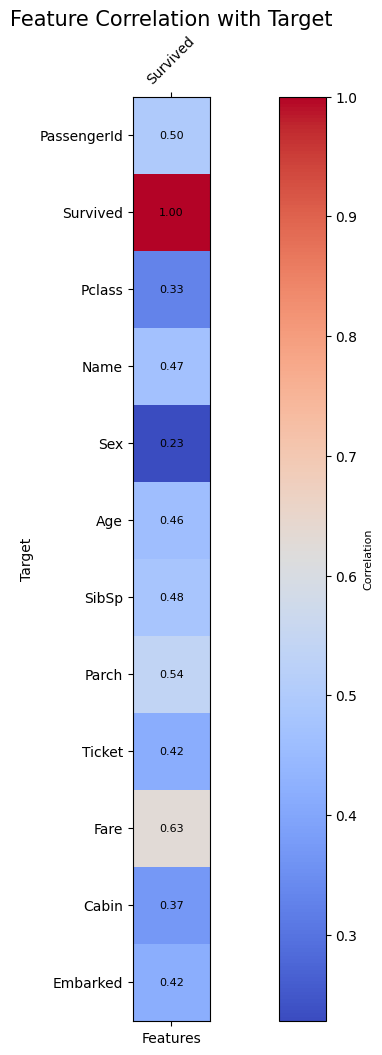

In [118]:
def feature_correlation_heatmap(dataframe, target_column):
    # Encode non-numeric categorical features
    label_encoders = {}
    for column in dataframe.select_dtypes(include=['object']).columns:
        label_encoder = LabelEncoder()
        dataframe[column] = label_encoder.fit_transform(dataframe[column])
        label_encoders[column] = label_encoder

    # Calculate correlation between features and target
    correlation_matrix = dataframe.corr()[[target_column]]

    # Normalize the correlation values to the range [0, 1]
    correlation_matrix[target_column] = (correlation_matrix[target_column] + 1) / 2

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(18, 12))
    cax = ax.matshow(correlation_matrix, cmap='coolwarm')

    # Customize the plot
    plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, fontsize=10)
    plt.yticks(range(len(correlation_matrix.index)), correlation_matrix.index, fontsize=10)
    plt.xlabel('Features', fontsize=10)
    plt.ylabel('Target', fontsize=10)
    plt.title('Feature Correlation with Target', fontsize=15)

    # Add colorbar
    cbar = fig.colorbar(cax)
    cbar.set_label('Correlation', fontsize=8)

    # Display original labels for categorical features
    for i, column in enumerate(dataframe.select_dtypes(include=['object']).columns):
        ax.set_xticklabels([col if col not in label_encoders else label_encoders[col].inverse_transform([col])[0] for col in correlation_matrix.columns], fontsize=10)

     # Increase the size of x-axis tick labels
    ax.tick_params(axis='x', which='both', labelsize=10)

    # Annotate each cell with the correlation value
    for i in range(len(correlation_matrix.index)):
        for j in range(len(correlation_matrix.columns)):
            text = f"{correlation_matrix.iloc[i, j]:.2f}"
            ax.text(j, i, text, ha='center', va='center', fontsize=10 - 2, color='black')

    plt.show()

feature_correlation_heatmap(train_data, 'Survived')


# Data pre-processing

#### Nguyễn Quỳnh Như (Update by Ngô Trọng Nhân)

### Feature selection

In [119]:
# With human knowledge, we can easily recognize that the ID, Name, Ticket and Cabin of the Passenger, 
# although they have a relatively high correlation on the heatmap, are certainly not 
# decisive factors for the survival of the Passenger. Therefore, we will exclude these four features from the training data.
train_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

### Label encoding 

In [120]:
# Encode categorical variables
train_data = pd.get_dummies(train_data, columns=['Sex', 'Embarked'])
test_data = pd.get_dummies(test_data, columns=['Sex', 'Embarked'])


### Missing value

In [121]:
from sklearn.impute import SimpleImputer

#Handle missing value with median
def handle_missing_values(x_train):
    imputer = SimpleImputer(strategy='median')

    x_train_imputed = pd.DataFrame(imputer.fit_transform(x_train), columns=x_train.columns)

    return x_train_imputed


train_data = handle_missing_values(train_data)
test_data = handle_missing_values(test_data)

In [122]:
#Check missing value
def display_missing(data):    
    for col in data.columns.tolist():          
        print('{} column missing values: {}'.format(col, data[col].isnull().sum()))
    print('\n')
    
display_missing(train_data)

Survived column missing values: 0
Pclass column missing values: 0
Age column missing values: 0
SibSp column missing values: 0
Parch column missing values: 0
Fare column missing values: 0
Sex_0 column missing values: 0
Sex_1 column missing values: 0
Embarked_0 column missing values: 0
Embarked_1 column missing values: 0
Embarked_2 column missing values: 0
Embarked_3 column missing values: 0




### Normalization

In [123]:
# Normalize with standard scaler
scaler = StandardScaler()
train_data[['Age', 'Fare', 'Pclass']] = scaler.fit_transform(train_data[['Age', 'Fare', 'Pclass']])
test_data[['Age', 'Fare', 'Pclass']] = scaler.transform(test_data[['Age', 'Fare', 'Pclass']])

## Data for training model

In [124]:
X = train_data.drop('Survived', axis=1)
y = train_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [125]:
X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_0,Sex_1,Embarked_0,Embarked_1,Embarked_2,Embarked_3
331,-1.566107,1.240235,0.0,0.0,-0.074583,0.0,1.0,0.0,0.0,1.0,0.0
733,-0.369365,-0.488887,0.0,0.0,-0.386671,0.0,1.0,0.0,0.0,1.0,0.0
382,0.827377,0.202762,0.0,0.0,-0.488854,0.0,1.0,0.0,0.0,1.0,0.0
704,0.827377,-0.258337,1.0,0.0,-0.490280,0.0,1.0,0.0,0.0,1.0,0.0
813,0.827377,-1.795334,4.0,2.0,-0.018709,1.0,0.0,0.0,0.0,1.0,0.0


In [126]:
X_test.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_0,Sex_1,Embarked_0,Embarked_1,Embarked_2,Embarked_3
709,0.827377,-0.104637,1.0,1.0,-0.341452,0.0,1.0,1.0,0.0,0.0,0.0
439,-0.369365,0.125912,0.0,0.0,-0.437007,0.0,1.0,0.0,0.0,1.0,0.0
840,0.827377,-0.719436,0.0,0.0,-0.488854,0.0,1.0,0.0,0.0,1.0,0.0
720,-0.369365,-1.795334,0.0,1.0,0.016023,1.0,0.0,0.0,0.0,1.0,0.0
39,0.827377,-1.180535,1.0,0.0,-0.422074,1.0,0.0,1.0,0.0,0.0,0.0


In [127]:
y_train.head()

331    0.0
733    0.0
382    0.0
704    0.0
813    0.0
Name: Survived, dtype: float64

In [128]:
y_test.head()

709    1.0
439    0.0
840    0.0
720    1.0
39     1.0
Name: Survived, dtype: float64

## Trần Lê Gia Bảo

In [129]:
def score_show(model, y_test, y_pred, start_time1, end_time1, start_time2, end_time2):
  show_report(y_test, y_pred)
  # show_kFold(model)
  ls = show_time(start_time1, end_time1, start_time2, end_time2)
  print("Training time: %.2f (s)" % ls[0])
  print("Testing time: %.2f (s)" % ls[1])
  show_sample_results(y_test, y_pred)
  display_confusion_matrix(y_test, y_pred)

def show_report(y_test, y_pred):
  print(classification_report(y_test, y_pred, target_names = ['Not Survived', 'Survived']))

def save_report(y_test, y_pred, start_time1, end_time1, start_time2, end_time2):
  report = classification_report(y_test, y_pred, target_names = ['Not Survived', 'Survived'], output_dict=True)
  time = show_time(start_time1, end_time1, start_time2, end_time2)
  return report, time

def show_time(start_time1, end_time1, start_time2, end_time2):
  train_time = (end_time1 - start_time1)
  test_time = (end_time2 - start_time2)
  ls = [train_time, test_time]
  return ls

def show_kFold(model):
  if model != None:
    scores = cross_val_score(model, X_train, y_train, cv = 5, scoring='accuracy')
    print("k-Fold Cross Validation:")
    print('Cross-validation scores:{}'.format(scores))
    print('Average cross-validation score: {:.4f}'.format(scores.mean()))

def show_sample_results(y_test, y_pred):
  df2 = pd.DataFrame({"Y_pred" : y_pred,"Y_test": y_test})
  print("\n",df2.head(15))

def display_confusion_matrix(y_test, y_pred, title = ''):
  confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
  cmx_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['Not Survived', 'Survived'])
  fig, ax = plt.subplots(figsize=(8,5))
  ax.grid(False)
  cmx_display.plot(ax=ax)
  plt.title(title)

# Model

### Logistic Regression

              precision    recall  f1-score   support

Not Survived       0.82      0.86      0.84       105
    Survived       0.78      0.73      0.76        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.80       179
weighted avg       0.80      0.80      0.80       179

Training time: 0.04 (s)
Testing time: 0.00 (s)

      Y_pred  Y_test
709     0.0     1.0
439     0.0     0.0
840     0.0     0.0
720     1.0     1.0
39      1.0     1.0
290     1.0     1.0
300     1.0     1.0
333     0.0     0.0
208     1.0     1.0
136     1.0     1.0
137     0.0     0.0
696     0.0     0.0
485     0.0     0.0
244     0.0     0.0
344     0.0     0.0


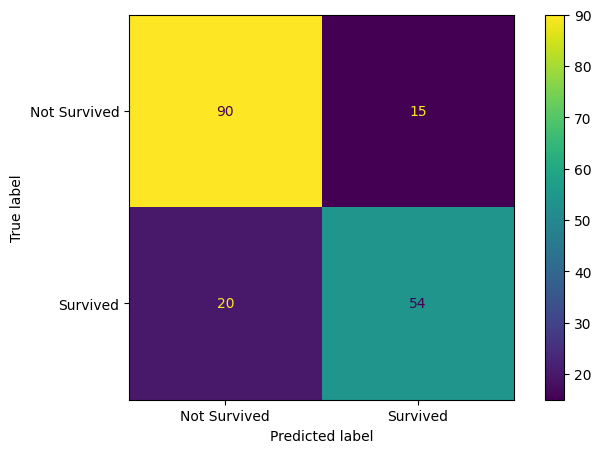

In [130]:
# Bắt đầu tính thời gian huấn luyện
start_time1 = time.time()

# Tạo một pipeline bao gồm việc scale dữ liệu và mô hình logistic regression
logistic_regression_pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(solver='saga', max_iter=5000)  # Sử dụng solver 'saga' và tăng số lần lặp
)
# Huấn luyện mô hình Logistic Regression trên tập dữ liệu huấn luyện
logistic_regression_pipeline.fit(X_train, y_train)

# Kết thúc tính thời gian huấn luyện
end_time1 = time.time()

# Bắt đầu tính thời gian dự đoán
start_time2 = time.time()

# Thực hiện dự đoán trên tập dữ liệu kiểm tra
y_pred = logistic_regression_pipeline.predict(X_test)

# Kết thúc tính thời gian dự đoán
end_time2 = time.time()

score_show(logistic_regression_pipeline, y_test, y_pred, start_time1, end_time1, start_time2, end_time2)
logistic_regression_score, logistic_regression_time = save_report(y_test, y_pred, start_time1, end_time1, start_time2, end_time2)


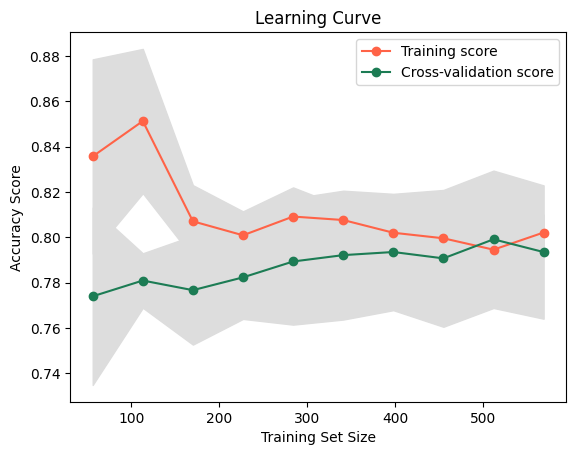

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Tạo một pipeline bao gồm việc scale dữ liệu và mô hình logistic regression
model = make_pipeline(StandardScaler(), LogisticRegression())

# Tính toán learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

# Tính trung bình và độ lệch chuẩn cho train và test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Vẽ đồ thị
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")
plt.plot(train_sizes, train_mean, 'o-', color="#FF6347", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="#1C7C54", label="Cross-validation score")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.show()


### KNeighborsClassifier

              precision    recall  f1-score   support

Not Survived       0.79      0.90      0.84       105
    Survived       0.83      0.66      0.74        74

    accuracy                           0.80       179
   macro avg       0.81      0.78      0.79       179
weighted avg       0.81      0.80      0.80       179

Training time: 0.01 (s)
Testing time: 0.02 (s)

      Y_pred  Y_test
709     0.0     1.0
439     0.0     0.0
840     0.0     0.0
720     1.0     1.0
39      1.0     1.0
290     1.0     1.0
300     1.0     1.0
333     0.0     0.0
208     1.0     1.0
136     1.0     1.0
137     0.0     0.0
696     0.0     0.0
485     0.0     0.0
244     0.0     0.0
344     0.0     0.0


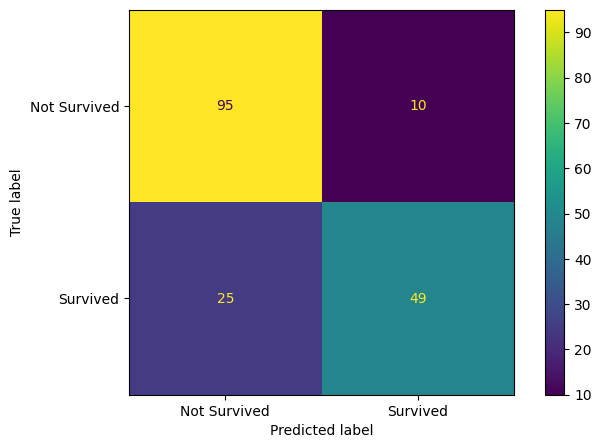

In [132]:
start_time1 = time.time()
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train , y_train)
end_time1 = time.time()
start_time2 = time.time()
y_pred = knn.predict(X_test)
end_time2 = time.time()

score_show(knn, y_test, y_pred, start_time1, end_time1, start_time2, end_time2)
knn_score, knn_time  = save_report(y_test, y_pred, start_time1, end_time1, start_time2, end_time2)

### DecisionTreeClassifier

              precision    recall  f1-score   support

Not Survived       0.79      0.89      0.84       105
    Survived       0.81      0.68      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

Training time: 0.00 (s)
Testing time: 0.00 (s)

      Y_pred  Y_test
709     0.0     1.0
439     0.0     0.0
840     0.0     0.0
720     1.0     1.0
39      1.0     1.0
290     1.0     1.0
300     1.0     1.0
333     0.0     0.0
208     1.0     1.0
136     1.0     1.0
137     0.0     0.0
696     0.0     0.0
485     0.0     0.0
244     0.0     0.0
344     0.0     0.0


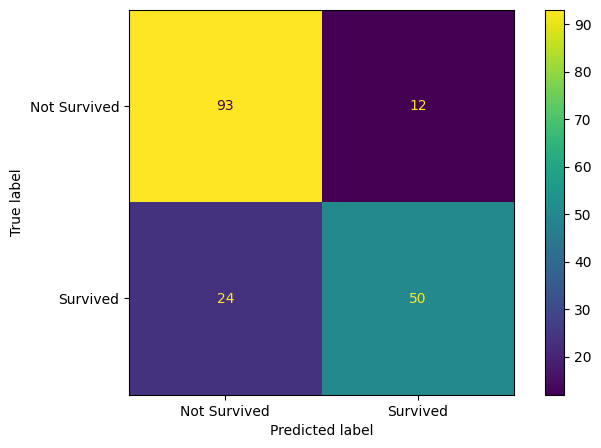

In [133]:
start_time1 = time.time()
dt=DecisionTreeClassifier(max_depth=7)
dt.fit(X_train, y_train)
end_time1 = time.time()
start_time2 = time.time()
y_pred = dt.predict(X_test)
end_time2 = time.time()

score_show(dt, y_test, y_pred, start_time1, end_time1, start_time2, end_time2)
dt_score, dt_time = save_report(y_test, y_pred, start_time1, end_time1, start_time2, end_time2)

### SVM(Support Vector Machines)

              precision    recall  f1-score   support

Not Survived       0.80      0.84      0.82       105
    Survived       0.75      0.70      0.73        74

    accuracy                           0.78       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179

Training time: 0.02 (s)
Testing time: 0.01 (s)

      Y_pred  Y_test
709     0.0     1.0
439     0.0     0.0
840     0.0     0.0
720     1.0     1.0
39      1.0     1.0
290     1.0     1.0
300     1.0     1.0
333     0.0     0.0
208     1.0     1.0
136     1.0     1.0
137     0.0     0.0
696     0.0     0.0
485     1.0     0.0
244     0.0     0.0
344     0.0     0.0


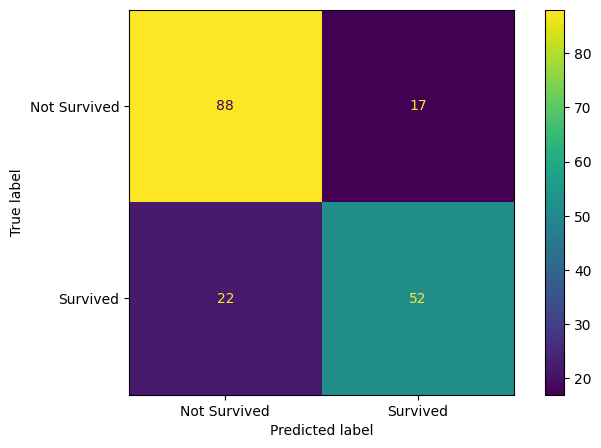

In [134]:
start_time1 = time.time()
svc=SVC(kernel="linear")
svc.fit(X_train, y_train)
end_time1 = time.time()
start_time2 = time.time()
y_pred = svc.predict(X_test)
end_time2 = time.time()

score_show(None, y_test, y_pred, start_time1, end_time1, start_time2, end_time2)
svc_score, svc_time = save_report(y_test, y_pred, start_time1, end_time1, start_time2, end_time2)

### RandomForestClassifier

              precision    recall  f1-score   support

Not Survived       0.84      0.85      0.84       105
    Survived       0.78      0.77      0.78        74

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179

Training time: 0.58 (s)
Testing time: 0.02 (s)

      Y_pred  Y_test
709     0.0     1.0
439     0.0     0.0
840     0.0     0.0
720     1.0     1.0
39      0.0     1.0
290     1.0     1.0
300     1.0     1.0
333     0.0     0.0
208     1.0     1.0
136     1.0     1.0
137     0.0     0.0
696     0.0     0.0
485     0.0     0.0
244     0.0     0.0
344     0.0     0.0


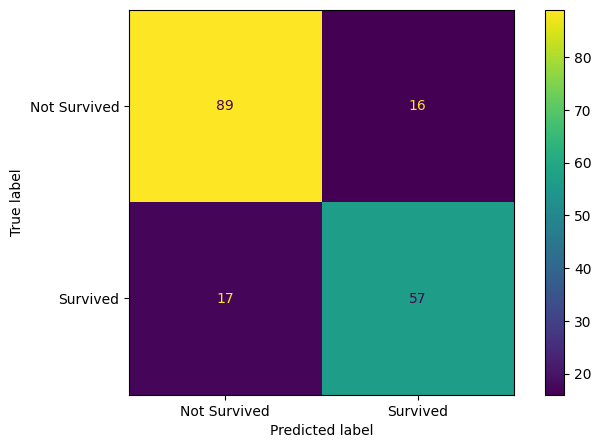

In [135]:
start_time1_rf = time.time()
rf=RandomForestClassifier(n_estimators=200,criterion="entropy")
rf.fit(X_train, y_train)
end_time1_rf = time.time()
start_time2_rf = time.time()
y_pred_rf = rf.predict(X_test)
end_time2_rf = time.time()

score_show(rf, y_test, y_pred_rf, start_time1_rf, end_time1_rf, start_time2_rf, end_time2_rf)
rf_score, rf_time = save_report(y_test, y_pred_rf, start_time1_rf, end_time1_rf, start_time2_rf, end_time2_rf)

### Stochastic Gradient Descent

              precision    recall  f1-score   support

Not Survived       0.82      0.81      0.81       105
    Survived       0.73      0.74      0.74        74

    accuracy                           0.78       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.78      0.78      0.78       179

Training time: 0.01 (s)
Testing time: 0.00 (s)

      Y_pred  Y_test
709     0.0     1.0
439     0.0     0.0
840     0.0     0.0
720     1.0     1.0
39      1.0     1.0
290     1.0     1.0
300     1.0     1.0
333     0.0     0.0
208     1.0     1.0
136     1.0     1.0
137     0.0     0.0
696     0.0     0.0
485     1.0     0.0
244     0.0     0.0
344     0.0     0.0


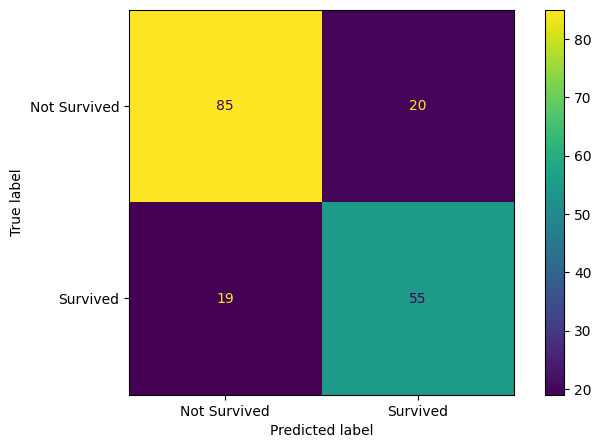

In [136]:
start_time1 = time.time()
sgd = SGDClassifier(max_iter=1000, tol=1e-3)
sgd.fit(X_train , y_train)
end_time1 = time.time()
start_time2 = time.time()
y_pred = sgd.predict(X_test)
end_time2 = time.time()

score_show(sgd, y_test, y_pred, start_time1, end_time1, start_time2, end_time2)
sgd_score, sgd_time  = save_report(y_test, y_pred, start_time1, end_time1, start_time2, end_time2)

## Ensemble Learning

1. Bagging (Bootstrap Aggregating)
2. GradientBoostingClassifier
3. Stacking

### Bagging (Bootstrap Aggregating)

C:\Users\VTP\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


              precision    recall  f1-score   support

Not Survived       0.83      0.85      0.84       105
    Survived       0.78      0.76      0.77        74

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

Training time: 0.46 (s)
Testing time: 0.02 (s)

      Y_pred  Y_test
709     0.0     1.0
439     0.0     0.0
840     0.0     0.0
720     1.0     1.0
39      0.0     1.0
290     1.0     1.0
300     1.0     1.0
333     0.0     0.0
208     1.0     1.0
136     1.0     1.0
137     1.0     0.0
696     0.0     0.0
485     0.0     0.0
244     0.0     0.0
344     0.0     0.0


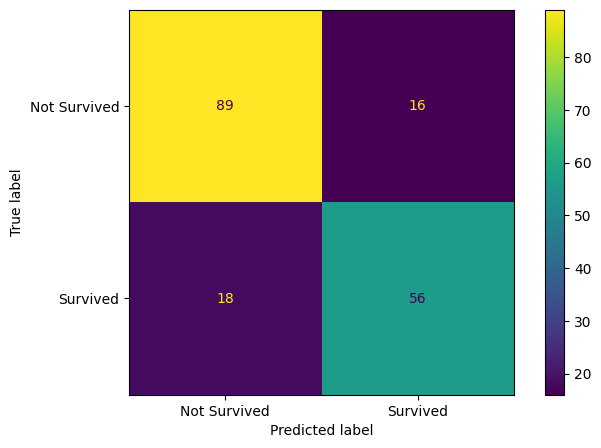

In [137]:
# Tạo một mô hình cơ sở (ở đây sử dụng Decision Tree)
base_estimator = DecisionTreeClassifier()
# Tạo mô hình Bagging
bagging_model = BaggingClassifier(
    base_estimator=base_estimator,
    n_estimators=100,  # Số lượng mô hình cơ sở
    random_state=0
)
start_time1_bg = time.time()
bagging_model.fit(X_train, y_train)
end_time1_bg = time.time()
start_time2_bg = time.time()
y_pred_bg = bagging_model.predict(X_test)
end_time2_bg = time.time()
accuracy_bg = accuracy_score(y_test, y_pred_bg)

score_show(bagging_model, y_test, y_pred_bg, start_time1_bg, end_time1_bg, start_time2_bg, end_time2_bg)
bagging_score, bagging_time = save_report(y_test, y_pred_bg, start_time1_bg, end_time1_bg, start_time2_bg, end_time2_bg)

### GradientBoostingClassifier

              precision    recall  f1-score   support

Not Survived       0.80      0.90      0.85       105
    Survived       0.82      0.69      0.75        74

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.81      0.81       179

Training time: 0.22 (s)
Testing time: 0.00 (s)

      Y_pred  Y_test
709     0.0     1.0
439     0.0     0.0
840     0.0     0.0
720     1.0     1.0
39      1.0     1.0
290     1.0     1.0
300     1.0     1.0
333     0.0     0.0
208     1.0     1.0
136     1.0     1.0
137     0.0     0.0
696     0.0     0.0
485     0.0     0.0
244     0.0     0.0
344     0.0     0.0


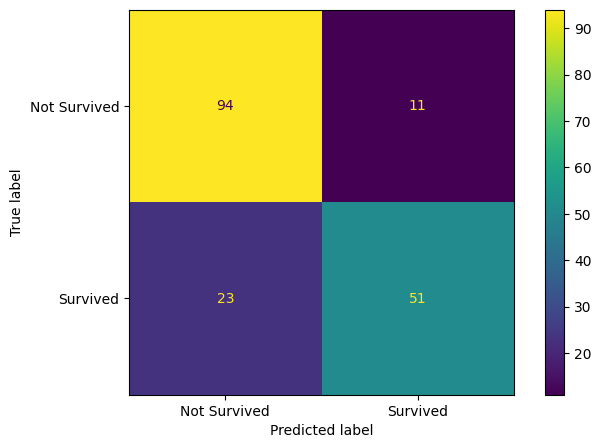

In [138]:
start_time1 = time.time()
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)
gb_clf.fit(X_train, y_train)
end_time1 = time.time()
start_time2 = time.time()
y_pred = gb_clf.predict(X_test)
end_time2 = time.time()
score_show(gb_clf, y_test, y_pred, start_time1, end_time1, start_time2, end_time2)
gradient_boosting_score, gradient_boosting_time = save_report(y_test, y_pred, start_time1, end_time1, start_time2, end_time2)

### Stacking

              precision    recall  f1-score   support

Not Survived       0.82      0.79      0.81       105
    Survived       0.72      0.76      0.74        74

    accuracy                           0.78       179
   macro avg       0.77      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179

Training time: 0.27 (s)
Testing time: 0.00 (s)

      Y_pred  Y_test
709     0.0     1.0
439     0.0     0.0
840     0.0     0.0
720     1.0     1.0
39      0.0     1.0
290     1.0     1.0
300     1.0     1.0
333     1.0     0.0
208     1.0     1.0
136     1.0     1.0
137     1.0     0.0
696     0.0     0.0
485     0.0     0.0
244     1.0     0.0
344     0.0     0.0


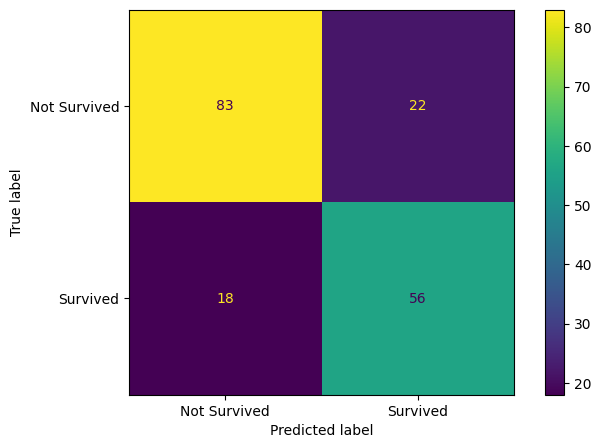

In [139]:
logistic_regression = LogisticRegression(solver='saga', max_iter=5000)
svm_model = SVC(kernel='linear')

# Tạo mô hình Stacking
stacking_model = StackingClassifier(
    estimators=[
        ('lr', logistic_regression),
        ('svm', svm_model)
    ],
    final_estimator=DecisionTreeClassifier()
)

start_time1 = time.time()
stacking_model.fit(X_train, y_train)
end_time1 = time.time()
start_time2 = time.time()
y_pred = stacking_model.predict(X_test)
end_time2 = time.time()
score_show(stacking_model, y_test, y_pred, start_time1, end_time1, start_time2, end_time2)
ensemble_score, ensemble_time = save_report(y_test, y_pred, start_time1, end_time1, start_time2, end_time2)

## Ngô Trọng Nhân

### Feedforward Neural Network

In [140]:
# Train and evaluate a Feedforward Neural Network
ffnn_1 = Sequential()
ffnn_1.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
ffnn_1.add(Dense(32, activation='relu'))
ffnn_1.add(Dense(1, activation='sigmoid'))
ffnn_1.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
start_time1_ffnn = time.time()
ffnn_1.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))
end_time1_ffnn = time.time()
start_time2_ffnn = time.time()
ffnn_1_pred_prob = ffnn_1.predict(X_test)
ffnn_1_pred = (ffnn_1_pred_prob > 0.5).astype(int).flatten()
end_time2_ffnn = time.time()

Epoch 1/100
23/23 [==============================] - 1s 10ms/step - loss: 0.6656 - accuracy: 0.6110 - val_loss: 0.5898 - val_accuracy: 0.7430
Epoch 2/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5571 - accuracy: 0.7374 - val_loss: 0.5087 - val_accuracy: 0.7765
Epoch 3/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5021 - accuracy: 0.7697 - val_loss: 0.4541 - val_accuracy: 0.7933
Epoch 4/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4640 - accuracy: 0.7978 - val_loss: 0.4219 - val_accuracy: 0.8212
Epoch 5/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4418 - accuracy: 0.8076 - val_loss: 0.4108 - val_accuracy: 0.8156
Epoch 6/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4312 - accuracy: 0.8188 - val_loss: 0.4064 - val_accuracy: 0.8156
Epoch 7/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4242 - accuracy: 0.8118 - val_loss: 0.4065 - val_accuracy: 0.8212
Epoch 8/100


              precision    recall  f1-score   support

Not Survived       0.81      0.87      0.83       105
    Survived       0.79      0.70      0.74        74

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

Training time: 9.63 (s)
Testing time: 0.12 (s)

      Y_pred  Y_test
709       0     1.0
439       0     0.0
840       0     0.0
720       1     1.0
39        0     1.0
290       1     1.0
300       1     1.0
333       0     0.0
208       1     1.0
136       1     1.0
137       0     0.0
696       0     0.0
485       0     0.0
244       0     0.0
344       0     0.0


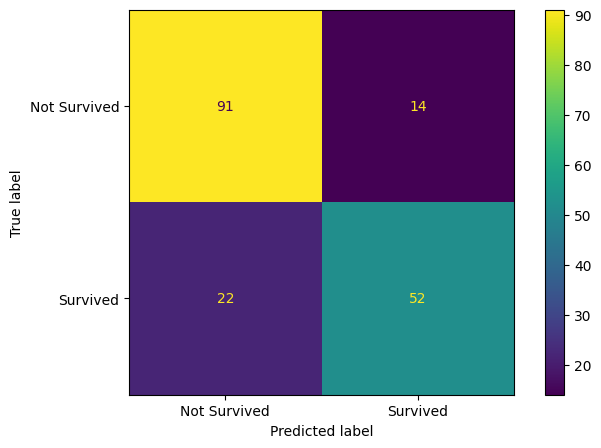

In [141]:
score_show(ffnn_1, y_test, ffnn_1_pred, start_time1_ffnn, end_time1_ffnn, start_time2_ffnn, end_time2_ffnn)
ffnn_1_score, ffnn_1_time = save_report(y_test, ffnn_1_pred, start_time1_ffnn, end_time1_ffnn, start_time2_ffnn, end_time2_ffnn)

### Recurrent Neural Network

In [142]:
# Train and evaluate a Recurrent Neural Network
X_train_rnn = X_train
X_test_rnn = X_test
X_train_rnn = np.reshape(X_train_rnn.values, (X_train_rnn.shape[0], 1, X_train_rnn.shape[1]))
X_test_rnn = np.reshape(X_test_rnn.values, (X_test_rnn.shape[0], 1, X_test_rnn.shape[1]))
rnn_1 = Sequential()
rnn_1.add(LSTM(64, input_shape=(1, X_train.shape[1]), activation='relu'))
rnn_1.add(Dense(1, activation='sigmoid'))
rnn_1.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
start_time1_rnn = time.time()
rnn_1.fit(X_train_rnn, y_train, epochs=100, batch_size=32, validation_data=(X_test_rnn, y_test))
end_time1_rnn = time.time()
start_time2_rnn = time.time()
rnn_1_pred_prob = rnn_1.predict(X_test_rnn)
rnn_1_pred = (rnn_1_pred_prob > 0.5).astype(int).flatten()
end_time2_rnn = time.time()

Epoch 1/100
23/23 [==============================] - 2s 19ms/step - loss: 0.6875 - accuracy: 0.5576 - val_loss: 0.6763 - val_accuracy: 0.6536
Epoch 2/100
23/23 [==============================] - 0s 5ms/step - loss: 0.6590 - accuracy: 0.6966 - val_loss: 0.6492 - val_accuracy: 0.6927
Epoch 3/100
23/23 [==============================] - 0s 5ms/step - loss: 0.6272 - accuracy: 0.7163 - val_loss: 0.6141 - val_accuracy: 0.6872
Epoch 4/100
23/23 [==============================] - 0s 4ms/step - loss: 0.5901 - accuracy: 0.7346 - val_loss: 0.5721 - val_accuracy: 0.7095
Epoch 5/100
23/23 [==============================] - 0s 4ms/step - loss: 0.5512 - accuracy: 0.7570 - val_loss: 0.5268 - val_accuracy: 0.7486
Epoch 6/100
23/23 [==============================] - 0s 5ms/step - loss: 0.5173 - accuracy: 0.7851 - val_loss: 0.4901 - val_accuracy: 0.7486
Epoch 7/100
23/23 [==============================] - 0s 5ms/step - loss: 0.4905 - accuracy: 0.7907 - val_loss: 0.4632 - val_accuracy: 0.7821
Epoch 8/100


              precision    recall  f1-score   support

Not Survived       0.82      0.89      0.85       105
    Survived       0.82      0.72      0.76        74

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.81       179

Training time: 13.09 (s)
Testing time: 0.23 (s)

      Y_pred  Y_test
709       0     1.0
439       0     0.0
840       0     0.0
720       1     1.0
39        1     1.0
290       1     1.0
300       1     1.0
333       0     0.0
208       1     1.0
136       1     1.0
137       0     0.0
696       0     0.0
485       0     0.0
244       0     0.0
344       0     0.0


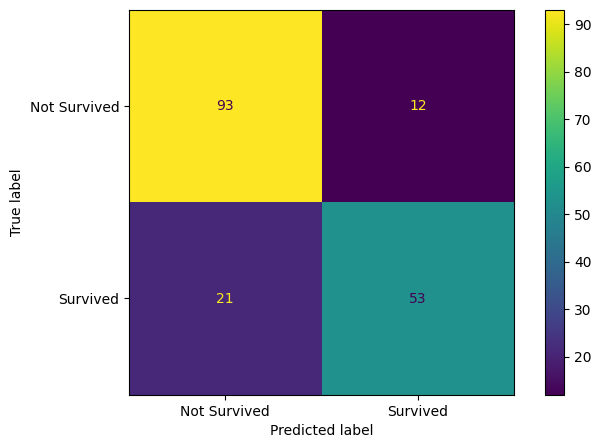

In [143]:
score_show(rnn_1, y_test, rnn_1_pred, start_time1_rnn, end_time1_rnn, start_time2_rnn, end_time2_rnn)
rnn_1_score, rnn_1_time = save_report(y_test, rnn_1_pred, start_time1_rnn, end_time1_rnn, start_time2_rnn, end_time2_rnn)

### Feedforward Neural Network avoid overfitting

In [144]:
# Train and evaluate Feedforward Neural Network with early stopping, dropout, and batch normalization
ffnn_2 = Sequential()
ffnn_2.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
ffnn_2.add(BatchNormalization())
ffnn_2.add(Dropout(0.2))
ffnn_2.add(Dense(32, activation='relu'))
ffnn_2.add(BatchNormalization())
ffnn_2.add(Dropout(0.2))
ffnn_2.add(Dense(1, activation='sigmoid'))
ffnn_2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10)
start_time1 = time.time()
ffnn_2.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])
end_time1 = time.time()
start_time2 = time.time()
ffnn_2_pred_prob = ffnn_2.predict(X_test)
ffnn_2_pred = (ffnn_2_pred_prob > 0.5).astype(int).flatten()
end_time2 = time.time()

Epoch 1/100
23/23 [==============================] - 2s 14ms/step - loss: 0.7889 - accuracy: 0.5843 - val_loss: 0.6464 - val_accuracy: 0.6983
Epoch 2/100
23/23 [==============================] - 0s 5ms/step - loss: 0.5590 - accuracy: 0.7219 - val_loss: 0.5878 - val_accuracy: 0.7709
Epoch 3/100
23/23 [==============================] - 0s 5ms/step - loss: 0.4841 - accuracy: 0.8006 - val_loss: 0.5558 - val_accuracy: 0.7654
Epoch 4/100
23/23 [==============================] - 0s 4ms/step - loss: 0.4878 - accuracy: 0.7851 - val_loss: 0.5322 - val_accuracy: 0.7877
Epoch 5/100
23/23 [==============================] - 0s 4ms/step - loss: 0.4698 - accuracy: 0.7978 - val_loss: 0.5097 - val_accuracy: 0.7821
Epoch 6/100
23/23 [==============================] - 0s 5ms/step - loss: 0.4549 - accuracy: 0.8020 - val_loss: 0.4924 - val_accuracy: 0.7821
Epoch 7/100
23/23 [==============================] - 0s 6ms/step - loss: 0.4551 - accuracy: 0.8062 - val_loss: 0.4724 - val_accuracy: 0.7821
Epoch 8/100


              precision    recall  f1-score   support

Not Survived       0.81      0.91      0.86       105
    Survived       0.85      0.70      0.77        74

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.82       179

Training time: 5.83 (s)
Testing time: 0.19 (s)

      Y_pred  Y_test
709       0     1.0
439       0     0.0
840       0     0.0
720       1     1.0
39        1     1.0
290       1     1.0
300       1     1.0
333       0     0.0
208       1     1.0
136       1     1.0
137       0     0.0
696       0     0.0
485       0     0.0
244       0     0.0
344       0     0.0


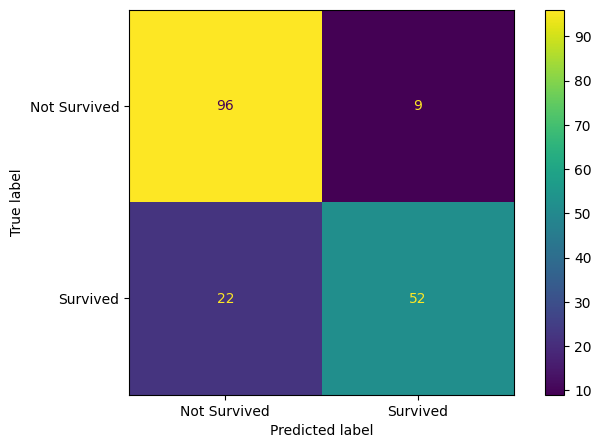

In [145]:
score_show(ffnn_2, y_test, ffnn_2_pred, start_time1, end_time1, start_time2, end_time2)
ffnn_2_score, ffnn_2_time = save_report(y_test, ffnn_2_pred, start_time1, end_time1, start_time2, end_time2)

### Recurrent Neural Network avoid overfitting

In [146]:
# Train and evaluate Recurrent Neural Network with early stopping, dropout, and batch normalization
rnn_2 = Sequential()
rnn_2.add(LSTM(64, input_shape=(1, X_train.shape[1]), activation='relu'))
rnn_2.add(BatchNormalization())
rnn_2.add(Dropout(0.2))
rnn_2.add(Dense(1, activation='sigmoid'))
rnn_2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10)
start_time1 = time.time()
rnn_2.fit(X_train_rnn, y_train, epochs=100, batch_size=32, validation_data=(X_test_rnn, y_test), callbacks=[early_stop])
end_time1 = time.time()
start_time2 = time.time()
rnn_2_pred_prob = rnn_2.predict(X_test_rnn)
rnn_2_pred = (rnn_2_pred_prob > 0.5).astype(int).flatten()
end_time2 = time.time()

Epoch 1/100
23/23 [==============================] - 3s 20ms/step - loss: 0.7283 - accuracy: 0.5730 - val_loss: 0.6696 - val_accuracy: 0.5810
Epoch 2/100
23/23 [==============================] - 0s 5ms/step - loss: 0.5202 - accuracy: 0.7851 - val_loss: 0.6548 - val_accuracy: 0.5866
Epoch 3/100
23/23 [==============================] - 0s 5ms/step - loss: 0.4886 - accuracy: 0.7753 - val_loss: 0.6468 - val_accuracy: 0.5866
Epoch 4/100
23/23 [==============================] - 0s 5ms/step - loss: 0.4594 - accuracy: 0.8062 - val_loss: 0.6406 - val_accuracy: 0.5866
Epoch 5/100
23/23 [==============================] - 0s 5ms/step - loss: 0.4394 - accuracy: 0.8062 - val_loss: 0.6355 - val_accuracy: 0.5866
Epoch 6/100
23/23 [==============================] - 0s 5ms/step - loss: 0.4211 - accuracy: 0.8258 - val_loss: 0.6263 - val_accuracy: 0.5866
Epoch 7/100
23/23 [==============================] - 0s 6ms/step - loss: 0.4306 - accuracy: 0.8202 - val_loss: 0.6204 - val_accuracy: 0.5866
Epoch 8/100


              precision    recall  f1-score   support

Not Survived       0.80      0.87      0.83       105
    Survived       0.78      0.69      0.73        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179

Training time: 8.05 (s)
Testing time: 0.36 (s)

      Y_pred  Y_test
709       0     1.0
439       0     0.0
840       0     0.0
720       1     1.0
39        1     1.0
290       1     1.0
300       1     1.0
333       0     0.0
208       1     1.0
136       1     1.0
137       0     0.0
696       0     0.0
485       0     0.0
244       0     0.0
344       0     0.0


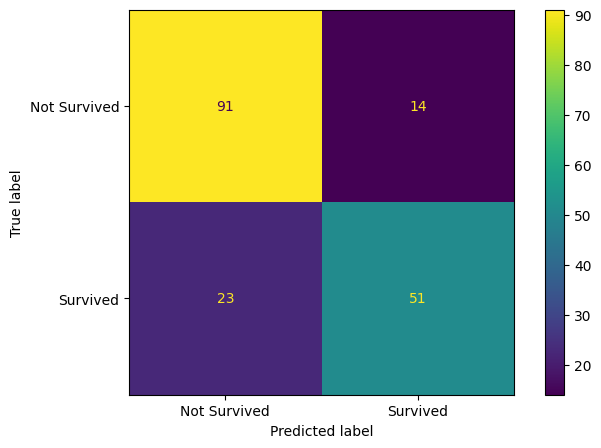

In [147]:
score_show(rnn_2, y_test, rnn_2_pred, start_time1, end_time1, start_time2, end_time2)
rnn_2_score, rnn_2_time = save_report(y_test, rnn_2_pred, start_time1, end_time1, start_time2, end_time2)

## Nguyễn Quỳnh Như - Analyze error cases and propose solutions

### Analyze error cases
##### Consider on 4 models: 
RandomForestClassifier (basic machine learning model); 
BaggingClassifier (Ensemble Learing model); 
Feed Forward Neural Network; 
Reccurent Neural Network 

### 1. RandomForest

#### Feature analysis - handling feature in error case

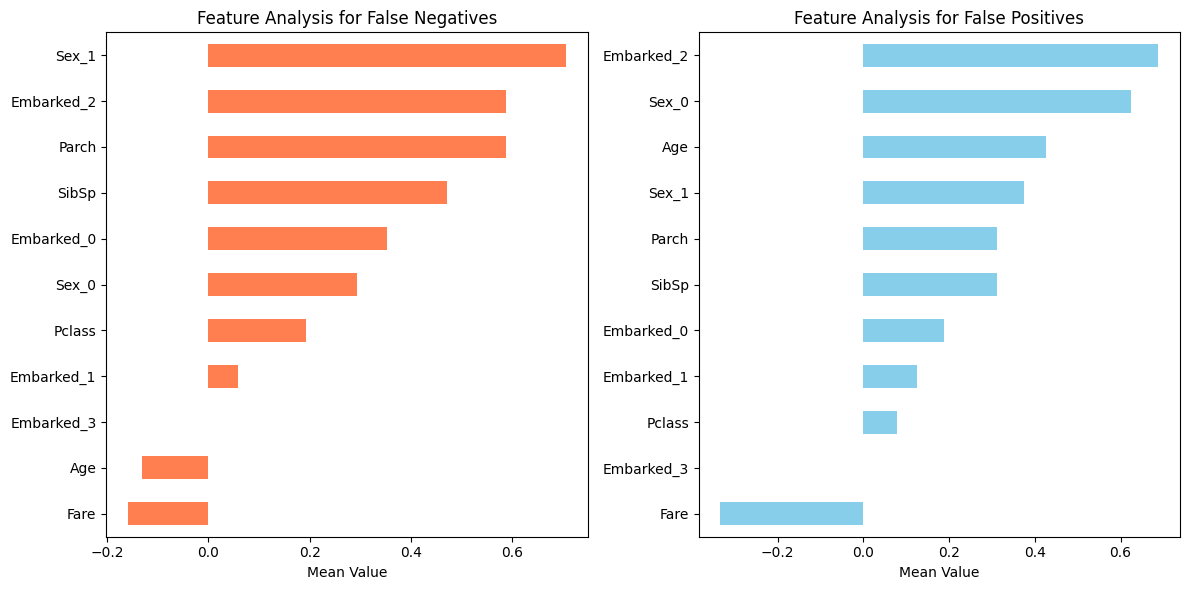

In [148]:
# False Negatives and False Positives - get all false case
false_negatives = X_test[(y_pred_rf == 0) & (y_test == 1)]
false_positives = X_test[(y_pred_rf == 1) & (y_test == 0)]

# Feature analysis for False Negatives - check the mean value of feature of wrong result
feature_analysis_fn = false_negatives.mean()

# Feature analysis for False Positives - check the mean value of feature of wrong result
feature_analysis_fp = false_positives.mean()

# Print or visualize feature analysis
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
feature_analysis_fn.sort_values().plot(kind='barh', color='coral')
plt.title('Feature Analysis for False Negatives')
plt.xlabel('Mean Value')

# Plotting Feature Analysis for False Positives
plt.subplot(1, 2, 2)
feature_analysis_fp.sort_values().plot(kind='barh', color='skyblue')
plt.title('Feature Analysis for False Positives')
plt.xlabel('Mean Value')

plt.tight_layout()
plt.show()


### Improvement by Cross-Validation and tunning parameter

Evaluation: Accuracy increased from 0.82 to 0.83

Cross-validation scores: [0.79020979 0.76223776 0.79577465 0.77464789 0.85211268]
              precision    recall  f1-score   support

Not Survived       0.85      0.86      0.85       105
    Survived       0.79      0.78      0.79        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

Training time: 0.90 (s)
Testing time: 0.02 (s)

      Y_pred  Y_test
709     0.0     1.0
439     0.0     0.0
840     0.0     0.0
720     1.0     1.0
39      0.0     1.0
290     1.0     1.0
300     1.0     1.0
333     0.0     0.0
208     1.0     1.0
136     1.0     1.0
137     0.0     0.0
696     0.0     0.0
485     0.0     0.0
244     0.0     0.0
344     0.0     0.0


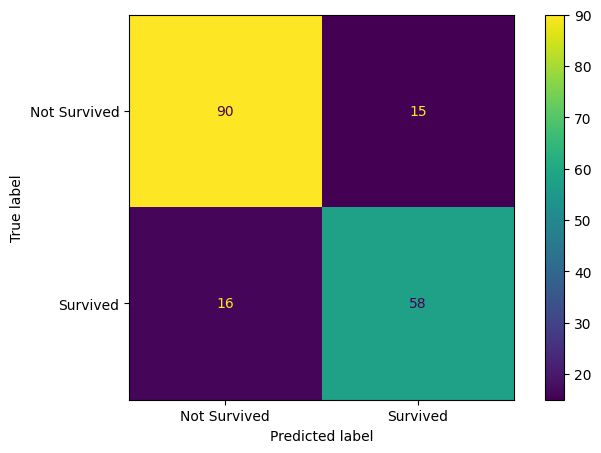

In [149]:
from sklearn.model_selection import cross_val_score

start_time1_rfimp = time.time()
rf_improve = RandomForestClassifier(n_estimators=200, criterion="entropy", class_weight='balanced')
rf_improve.fit(X_train, y_train)

end_time1_rfimp = time.time()
start_time2_rfimp = time.time()
y_pred_rfimp = rf_improve.predict(X_test)
end_time2_rfimp = time.time()

cv_scores = cross_val_score(rf_improve, X_train, y_train, cv=5)
print("Cross-validation scores:", cv_scores)

score_show(rf_improve, y_test, y_pred_rfimp, start_time1_rfimp, end_time1_rfimp, start_time2_rfimp, end_time2_rfimp)

### 2. BaggingClassifier

#### Feature analysis - handling feature in error case

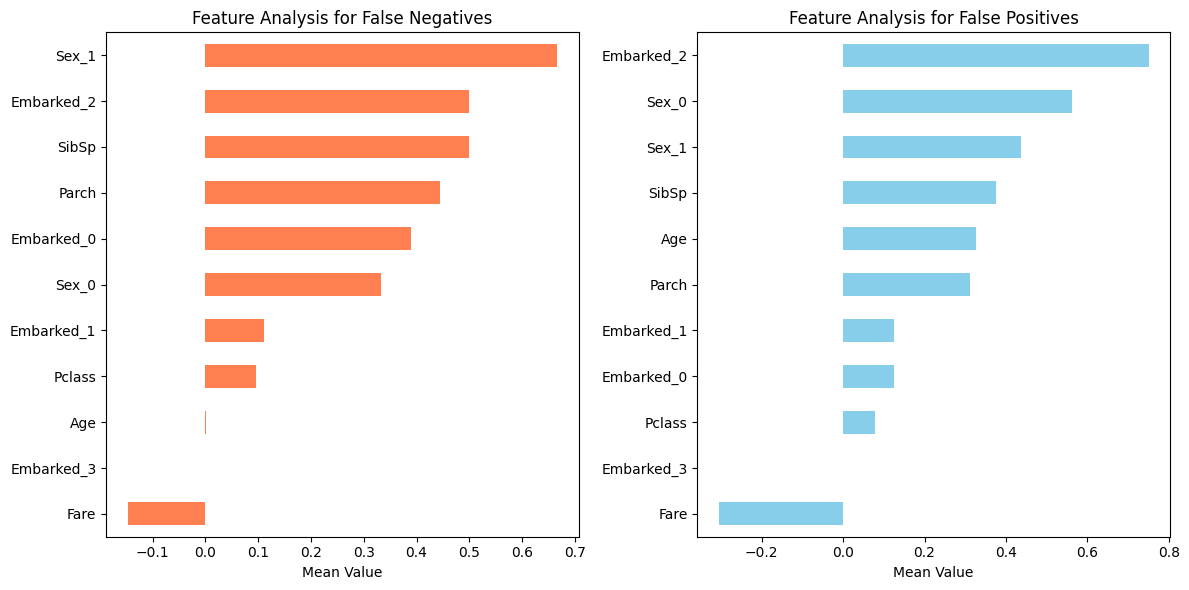

In [150]:
# False Negatives and False Positives - get all false case
false_negatives = X_test[(y_pred_bg == 0) & (y_test == 1)]
false_positives = X_test[(y_pred_bg == 1) & (y_test == 0)]

# Feature analysis for False Negatives - check the mean value of feature of wrong result
feature_analysis_fn = false_negatives.mean()

# Feature analysis for False Positives - check the mean value of feature of wrong result
feature_analysis_fp = false_positives.mean()

# Print or visualize feature analysis
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
feature_analysis_fn.sort_values().plot(kind='barh', color='coral')
plt.title('Feature Analysis for False Negatives')
plt.xlabel('Mean Value')

# Plotting Feature Analysis for False Positives
plt.subplot(1, 2, 2)
feature_analysis_fp.sort_values().plot(kind='barh', color='skyblue')
plt.title('Feature Analysis for False Positives')
plt.xlabel('Mean Value')

plt.tight_layout()
plt.show()


### Improvement by Cross-Validation and tunning parameter

Evaluation: Accuracy increased from 0.81 to 0.82

C:\Users\VTP\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\VTP\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\VTP\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\VTP\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
C:\Users\VTP\AppData\Roaming\Python\Python311\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version

Cross-validation scores: [0.77622378 0.74825175 0.81690141 0.77464789 0.81690141]
              precision    recall  f1-score   support

Not Survived       0.83      0.87      0.85       105
    Survived       0.80      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.81      0.82      0.81       179

Training time: 0.50 (s)
Testing time: 0.02 (s)

      Y_pred  Y_test
709     0.0     1.0
439     0.0     0.0
840     0.0     0.0
720     1.0     1.0
39      0.0     1.0
290     1.0     1.0
300     1.0     1.0
333     0.0     0.0
208     1.0     1.0
136     1.0     1.0
137     1.0     0.0
696     0.0     0.0
485     0.0     0.0
244     0.0     0.0
344     0.0     0.0


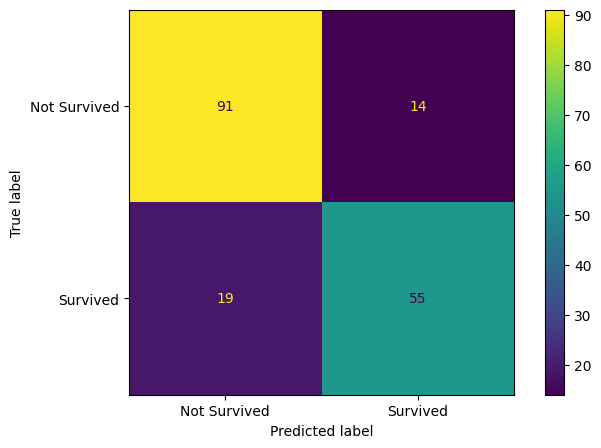

In [151]:
# Tạo mô hình Bagging
bagging_model_improve = BaggingClassifier(
    base_estimator= DecisionTreeClassifier(),
    n_estimators=100,  
    random_state=42 #tunning to 42
)
start_time1_bg_imp = time.time()
bagging_model_improve.fit(X_train, y_train)
end_time1_bg_imp = time.time()
start_time2_bg_imp = time.time()
y_pred_bg_imp = bagging_model_improve.predict(X_test)
end_time2_bg_imp = time.time()

cv_scores = cross_val_score(bagging_model_improve, X_train, y_train, cv=5)
print("Cross-validation scores:", cv_scores)
accuracy_bg_imp = accuracy_score(y_test, y_pred_bg)

score_show(bagging_model_improve, y_test, y_pred_bg_imp, start_time1_bg_imp, end_time1_bg_imp, start_time2_bg_imp, end_time2_bg_imp)

### 3. Feed forward neural network

#### Feature analysis - handling feature in error case

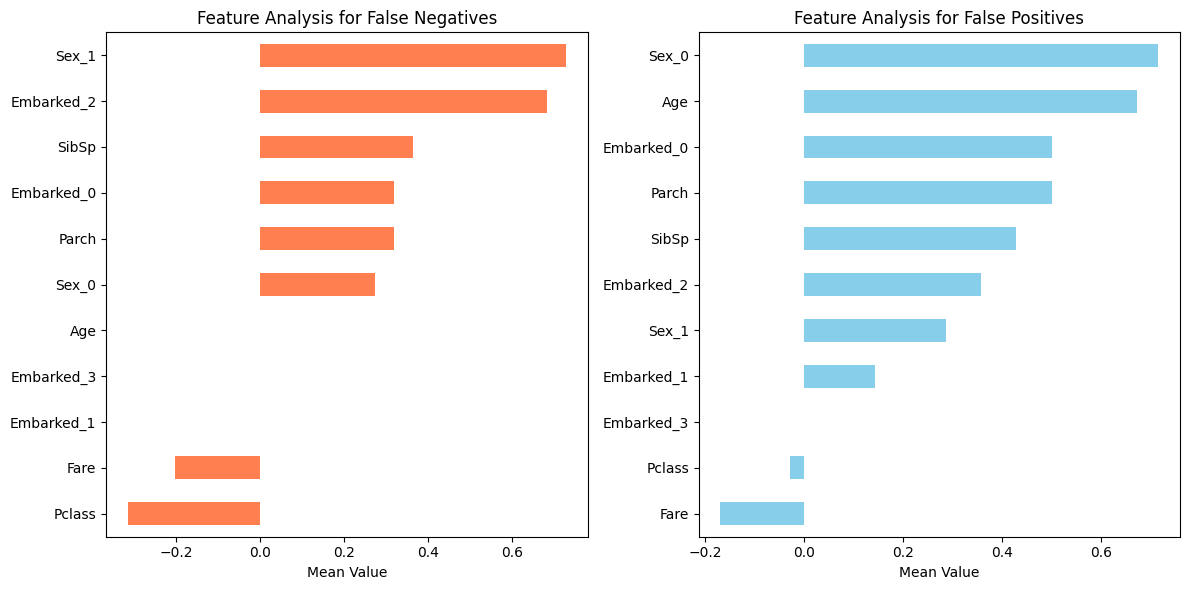

In [165]:
# False Negatives and False Positives - get all false case
false_negatives = X_test[(ffnn_1_pred == 0) & (y_test == 1)]
false_positives = X_test[(ffnn_1_pred == 1) & (y_test == 0)]

# Feature analysis for False Negatives - check the mean value of feature of wrong result
feature_analysis_fn = false_negatives.mean()

# Feature analysis for False Positives - check the mean value of feature of wrong result
feature_analysis_fp = false_positives.mean()

# Print or visualize feature analysis
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
feature_analysis_fn.sort_values().plot(kind='barh', color='coral')
plt.title('Feature Analysis for False Negatives')
plt.xlabel('Mean Value')

# Plotting Feature Analysis for False Positives
plt.subplot(1, 2, 2)
feature_analysis_fp.sort_values().plot(kind='barh', color='skyblue')
plt.title('Feature Analysis for False Positives')
plt.xlabel('Mean Value')

plt.tight_layout()
plt.show()


### Improve by add Batch Normalization layers and Adjust Learning Rate

Evaluation: Accuracy doesn't change (0.80) - but False Positive decrease  

Epoch 1/100
23/23 [==============================] - 3s 16ms/step - loss: 0.7445 - accuracy: 0.5618 - val_loss: 0.6447 - val_accuracy: 0.7263
Epoch 2/100
23/23 [==============================] - 0s 6ms/step - loss: 0.6330 - accuracy: 0.6713 - val_loss: 0.6104 - val_accuracy: 0.7095
Epoch 3/100
23/23 [==============================] - 0s 6ms/step - loss: 0.5665 - accuracy: 0.7191 - val_loss: 0.5883 - val_accuracy: 0.7095
Epoch 4/100
23/23 [==============================] - 0s 6ms/step - loss: 0.5298 - accuracy: 0.7402 - val_loss: 0.5714 - val_accuracy: 0.7095
Epoch 5/100
23/23 [==============================] - 0s 5ms/step - loss: 0.5135 - accuracy: 0.7711 - val_loss: 0.5525 - val_accuracy: 0.7151
Epoch 6/100
23/23 [==============================] - 0s 5ms/step - loss: 0.5232 - accuracy: 0.7669 - val_loss: 0.5367 - val_accuracy: 0.7095
Epoch 7/100
23/23 [==============================] - 0s 6ms/step - loss: 0.4897 - accuracy: 0.7865 - val_loss: 0.5157 - val_accuracy: 0.7095
Epoch 8/100


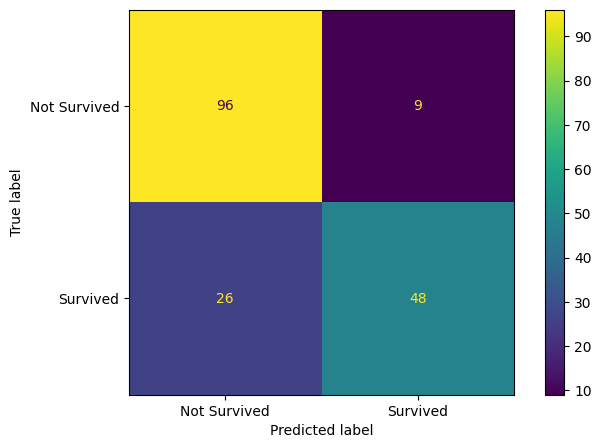

In [171]:
from keras.layers import Dense, BatchNormalization
import time

# Train and evaluate a Feedforward Neural Network with Batch Normalization
ffnn_3 = Sequential()
ffnn_3.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
ffnn_3.add(BatchNormalization())
ffnn_3.add(Dropout(0.2))
ffnn_3.add(Dense(32, activation='relu'))
ffnn_3.add(BatchNormalization())
ffnn_3.add(Dropout(0.2))
ffnn_3.add(Dense(32, activation='relu'))
ffnn_3.add(BatchNormalization())
ffnn_3.add(Dropout(0.2))
ffnn_3.add(Dense(1, activation='sigmoid'))
ffnn_3.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy']) 

# Training
start_time1_ffnn = time.time()
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
ffnn_3.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])
end_time1_ffnn = time.time()

# Prediction
start_time2_ffnn = time.time()
ffnn_3_pred_prob = ffnn_3.predict(X_test)
ffnn_3_pred = (ffnn_3_pred_prob > 0.5).astype(int).flatten()
end_time2_ffnn = time.time()

score_show(ffnn_3, y_test, ffnn_3_pred, start_time1, end_time1, start_time2, end_time2)


### 4. Recurrent Neural Network

#### Feature analysis - handling feature in error case

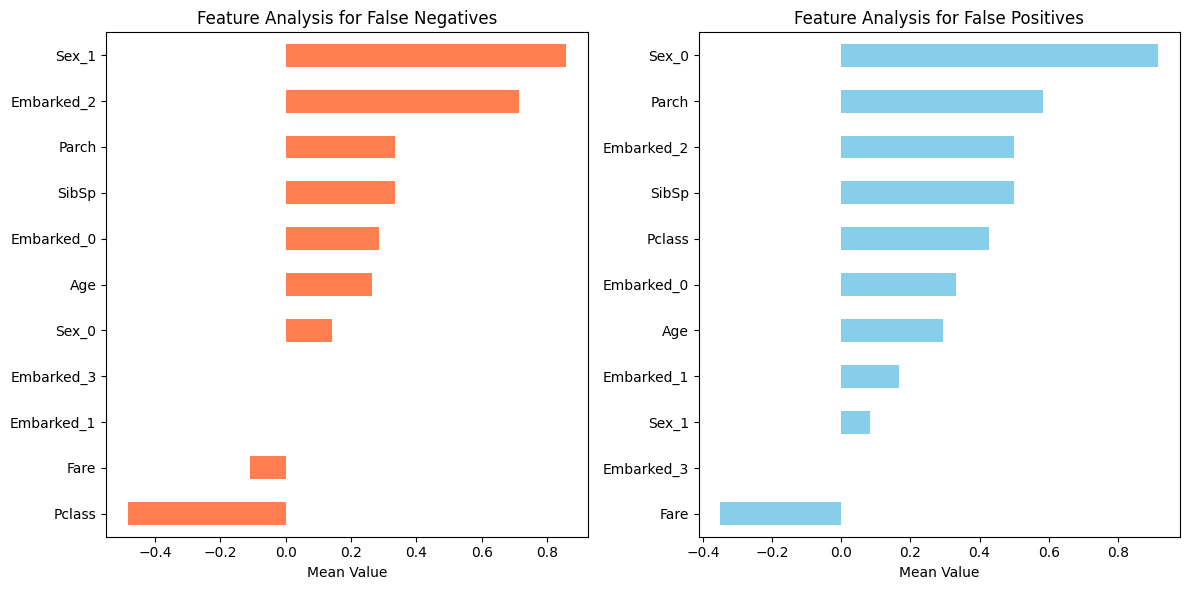

In [163]:
# False Negatives and False Positives - get all false case
false_negatives = X_test[(rnn_1_pred == 0) & (y_test == 1)]
false_positives = X_test[(rnn_1_pred == 1) & (y_test == 0)]

# Feature analysis for False Negatives - check the mean value of feature of wrong result
feature_analysis_fn = false_negatives.mean()

# Feature analysis for False Positives - check the mean value of feature of wrong result
feature_analysis_fp = false_positives.mean()

# Print or visualize feature analysis
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
feature_analysis_fn.sort_values().plot(kind='barh', color='coral')
plt.title('Feature Analysis for False Negatives')
plt.xlabel('Mean Value')

# Plotting Feature Analysis for False Positives
plt.subplot(1, 2, 2)
feature_analysis_fp.sort_values().plot(kind='barh', color='skyblue')
plt.title('Feature Analysis for False Positives')
plt.xlabel('Mean Value')

plt.tight_layout()
plt.show()


### Improve by using LSTM & Early Stopping:

Comment: Does not increase accuracy

Epoch 1/100
23/23 [==============================] - 4s 25ms/step - loss: 0.6880 - accuracy: 0.6306 - val_loss: 0.6826 - val_accuracy: 0.5922
Epoch 2/100
23/23 [==============================] - 0s 6ms/step - loss: 0.6708 - accuracy: 0.6404 - val_loss: 0.6574 - val_accuracy: 0.6034
Epoch 3/100
23/23 [==============================] - 0s 6ms/step - loss: 0.6264 - accuracy: 0.6798 - val_loss: 0.5937 - val_accuracy: 0.7039
Epoch 4/100
23/23 [==============================] - 0s 9ms/step - loss: 0.5574 - accuracy: 0.7135 - val_loss: 0.5121 - val_accuracy: 0.7486
Epoch 5/100
23/23 [==============================] - 0s 6ms/step - loss: 0.5027 - accuracy: 0.7753 - val_loss: 0.4611 - val_accuracy: 0.7765
Epoch 6/100
23/23 [==============================] - 0s 8ms/step - loss: 0.4703 - accuracy: 0.8048 - val_loss: 0.4366 - val_accuracy: 0.8045
Epoch 7/100
23/23 [==============================] - 0s 8ms/step - loss: 0.4521 - accuracy: 0.8076 - val_loss: 0.4227 - val_accuracy: 0.7989
Epoch 8/100


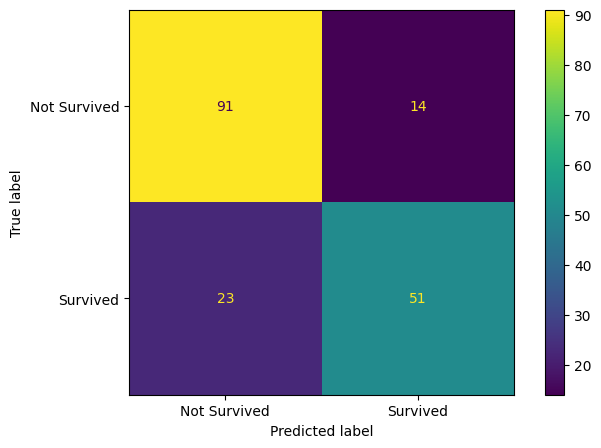

In [174]:
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

# Train and evaluate an improved LSTM-based Recurrent Neural Network
X_train_rnn = np.reshape(X_train.values, (X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))

# Improved LSTM-based RNN
rnn_3 = Sequential()
rnn_3.add(LSTM(64, input_shape=(1, X_train.shape[1]), activation='relu', return_sequences=True))
rnn_3.add(Dropout(0.2))
rnn_3.add(LSTM(64, activation='relu'))
rnn_3.add(Dropout(0.2))
rnn_3.add(Dense(1, activation='sigmoid'))

# Compile the model
rnn_3.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Training
start_time1_rnn = time.time()
rnn_3.fit(X_train_rnn, y_train, epochs=100, batch_size=32, validation_data=(X_test_rnn, y_test), callbacks=[early_stopping])
end_time1_rnn = time.time()

# Prediction
start_time2_rnn = time.time()
rnn_3_pred_prob = rnn_3.predict(X_test_rnn)
rnn_3_pred = (rnn_3_pred_prob > 0.5).astype(int).flatten()
end_time2_rnn = time.time()

score_show(rnn_3, y_test, rnn_2_pred, start_time1, end_time1, start_time2, end_time2)

